<a href="https://colab.research.google.com/github/ykitaguchi77/GravCont_classification_colab/blob/master/Assessment2.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Assessment**

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.utils.data as data
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import math
import shutil

#Advanced Pytorchから
import glob
import os.path as osp
import random
import json
from PIL import Image
from tqdm import tqdm
%matplotlib inline

#サポートパッチのインポート
from google.colab.patches import cv2_imshow
import cv2

plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set random seem for reproducibility
manualSeed = 1234
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.cuda.manual_seed(manualSeed)

torch.torch.backends.cudnn.benchmark = True
torch.torch.backends.cudnn.enabled = True


'''
grav: 甲状腺眼症
cont: コントロール
黒の空白を挿入することにより225px*225pxの画像を生成、EfficientNetを用いて転移学習
－－－－－－－－－－－－－－
データの構造
gravcont.zip ------grav
               |---cont
'''                                     

#google driveをcolabolatoryにマウント
from google.colab import drive
drive.mount('/content/drive')

Random Seed:  1234
Mounted at /content/drive


#**モジュール群**

In [7]:
#ModelNameをリストにする
ModelName_list = []
ModelName = ''
model_pred_prob = []
eval_index = []

def checkModelName(ModelName, ModelName_list):
    if ModelName in ModelName_list:
        raise Exception("This model has been already loaded")
    else:
        ModelName_list.append(ModelName)


# 入力画像の前処理をするクラス
# 訓練時と推論時で処理が異なる

"""
    画像の前処理クラス。訓練時、検証時で異なる動作をする。
    画像のサイズをリサイズし、色を標準化する。
    訓練時はRandomResizedCropとRandomHorizontalFlipでデータオーギュメンテーションする。


    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
"""

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.75,1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/My Drive/Grav_bootcamp/Posttrain_250px'
n_samples = len(data_dir)

image_datasets = datasets.ImageFolder(data_dir,data_transforms)
                  
dataloaders = torch.utils.data.DataLoader(image_datasets, batch_size=20,
                                             shuffle=True, num_workers=0)
dataset_sizes = len(image_datasets)
class_names = image_datasets.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



print(class_names)
k=0
for i in class_names:
    print(class_names[k]+"_train:"+str(len(os.listdir(path=data_dir + '/'+class_names[k]))))
    k+=1
k=0
for i in class_names:
    print(class_names[k]+"_val:"+str(len(os.listdir(path=data_dir + '/'+class_names[k]))))
    k+=1

print("test data set_total："+ str(len(image_datasets)))



['cont', 'grav']
cont_train:54
grav_train:54
cont_val:54
grav_val:54
test data set_total：108


#**Calculate Accuracy**

In [8]:
##########Calculate Accuracy#############
#valフォルダ内のファイル名を取得
image_path = glob.glob("/content/drive/My Drive/Grav_bootcamp/Posttrain_250px/*/*")
random.shuffle(image_path)  #表示順をランダムにする
print('number of images: ' +str(len(image_path)))
#print(image_path) 


#対象のパスからラベルを抜き出して表示
def getlabel(image_path):
      image_name = os.path.basename(image_path)
      label = os.path.basename(os.path.dirname(image_path))
      return(image_name, label)

'''
#変形後の画像を表示
def image_transform(image_path):

    image=Image.open(image_path)

    
    #変形した画像を表示する
    transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224)])
    image_transformed = transform(image)
    plt.imshow(np.array(image_transformed))
'''

#評価のための画像下処理
def image_transform(image_path):    
    image=Image.open(image_path)
    transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    image_tensor = transform(image)

    #バッチサイズの次元を先頭に追加した4Dテンソルに変換
    image_tensor.unsqueeze_(0)
    #print(image_tensor.size())  # torch.Size([1, 3, 224, 224])
    image_tensor = image_tensor.to(device) #model_ftをGPUに載せる

    return(image_tensor)

#モデルにした処理した画像を投入して予測結果を表示
def image_eval(image_tensor, label):
    
    if ModelName == 'Attention_branch_Network_ImageNet':
        _, output, _ = model_ft(image_tensor)
    else:
        output = model_ft(image_tensor)
    #print(output.size())  # torch.Size([1, 1000])
    #print(output)

    #評価モードにする
    model_ft.eval()

    #model_pred:クラス名前、prob:確率、pred:クラス番号
    prob, pred = torch.topk(nn.Softmax(dim=1)(output), 1)
    model_pred = class_names[pred]
    
    #甲状腺眼症のprobabilityを計算（classが0なら1から減算、classが1ならそのまま）
    prob = abs(1-float(prob)-float(pred))
 
    return model_pred, prob, pred


def showImage(image_path):
    #画像のインポート
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    #画像のリサイズ
    height = img.shape[0]
    width = img.shape[1]
    resized_img = cv2.resize(img, (int(width*300/height), 300))
    cv2_imshow(resized_img)

def calculateAccuracy (image_path):

    #ここからがメイン
    TP, FP, TN, FN, TP, FP, TN, FN = [0,0,0,0,0,0,0,0]
    image_name_list = []
    label_list = []
    model_pred_list = []
    hum_pred_list = []

    model_pred_class = []
    model_pred_prob = []

    for i in image_path:
          image_name, label = getlabel(i)  #画像の名前とラベルを取得
          image_tensor = image_transform(i)  #予測のための画像下処理
          model_pred, prob, pred = image_eval(image_tensor, label)  #予測結果を出力 

          #print('Image: '+ image_name)
          #print('Label: '+ label)
          #print('Pred: '+ model_pred)
          #showImage(i)  #画像を表示
          #print() #空白行を入れる
          time.sleep(0.1)

          image_name_list.append(image_name)
          label_list.append(label)
          model_pred_list.append(model_pred)

          model_pred_class.append(int(pred))
          model_pred_prob.append(float(prob))

          if label == class_names[0]:
              if model_pred == class_names[0]:
                  TP += 1
              else:
                  FN += 1
          elif label == class_names[1]:
              if model_pred == class_names[1]:
                  TN += 1
              else:
                  FP += 1
          

    print(TP, FN, TN, FP)

    #Accuracyを計算
    accuracy = (TP + TN)/ (TP + TN + FP + FN)
    precision  = TP/(FP + TP)
    recall = TP/(TP + FN)
    specificity = TN/(FP + TN)
    f_value = (2*recall*precision)/(recall+precision)
    
    #各指標をeval_indexに格納
    eval_index = accuracy, precision, recall, specificity, f_value

    print('Accuracy: ' + str(accuracy))
    print('Precision (positive predictive value): ' + str(precision))
    print('Recall (sensitivity): ' + str(recall))
    print('Specificity: ' + str(specificity))
    print('F_value: ' + str(f_value))

    #print(model_pred_class)
    #print(model_pred_prob)

    #return(accuracy, precision, recall, specificity, f_value)
    return model_pred_prob, label_list, eval_index


number of images: 108


#**ResNet50_VGGFace2のネットワーク**

In [9]:
import torch
import torch.nn as nn

ModelName = 'ResNet50_VGGFace2'
checkModelName(ModelName, ModelName_list)

class Resnet50_ft_dag(nn.Module):

    def __init__(self):
        super(Resnet50_ft_dag, self).__init__()
        self.meta = {'mean': [131.0912, 103.8827, 91.4953],
                     'std': [1, 1, 1],
                     'imageSize': [224, 224, 3]}
        self.conv1_7x7_s2 = nn.Conv2d(3, 64, kernel_size=[7, 7], stride=(2, 2), padding=(3, 3), bias=False)
        self.conv1_7x7_s2_bn = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv1_relu_7x7_s2 = nn.ReLU()
        self.pool1_3x3_s2 = nn.MaxPool2d(kernel_size=[3, 3], stride=[2, 2], padding=(0, 0), dilation=1, ceil_mode=True)
        self.conv2_1_1x1_reduce = nn.Conv2d(64, 64, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv2_1_1x1_reduce_bn = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2_1_1x1_reduce_relu = nn.ReLU()
        self.conv2_1_3x3 = nn.Conv2d(64, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv2_1_3x3_bn = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2_1_3x3_relu = nn.ReLU()
        self.conv2_1_1x1_increase = nn.Conv2d(64, 256, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv2_1_1x1_increase_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2_1_1x1_proj = nn.Conv2d(64, 256, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv2_1_1x1_proj_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2_1_relu = nn.ReLU()
        self.conv2_2_1x1_reduce = nn.Conv2d(256, 64, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv2_2_1x1_reduce_bn = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2_2_1x1_reduce_relu = nn.ReLU()
        self.conv2_2_3x3 = nn.Conv2d(64, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv2_2_3x3_bn = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2_2_3x3_relu = nn.ReLU()
        self.conv2_2_1x1_increase = nn.Conv2d(64, 256, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv2_2_1x1_increase_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2_2_relu = nn.ReLU()
        self.conv2_3_1x1_reduce = nn.Conv2d(256, 64, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv2_3_1x1_reduce_bn = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2_3_1x1_reduce_relu = nn.ReLU()
        self.conv2_3_3x3 = nn.Conv2d(64, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv2_3_3x3_bn = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2_3_3x3_relu = nn.ReLU()
        self.conv2_3_1x1_increase = nn.Conv2d(64, 256, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv2_3_1x1_increase_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2_3_relu = nn.ReLU()
        self.conv3_1_1x1_reduce = nn.Conv2d(256, 128, kernel_size=[1, 1], stride=(2, 2), bias=False)
        self.conv3_1_1x1_reduce_bn = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3_1_1x1_reduce_relu = nn.ReLU()
        self.conv3_1_3x3 = nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv3_1_3x3_bn = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3_1_3x3_relu = nn.ReLU()
        self.conv3_1_1x1_increase = nn.Conv2d(128, 512, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv3_1_1x1_increase_bn = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3_1_1x1_proj = nn.Conv2d(256, 512, kernel_size=[1, 1], stride=(2, 2), bias=False)
        self.conv3_1_1x1_proj_bn = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3_1_relu = nn.ReLU()
        self.conv3_2_1x1_reduce = nn.Conv2d(512, 128, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv3_2_1x1_reduce_bn = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3_2_1x1_reduce_relu = nn.ReLU()
        self.conv3_2_3x3 = nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv3_2_3x3_bn = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3_2_3x3_relu = nn.ReLU()
        self.conv3_2_1x1_increase = nn.Conv2d(128, 512, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv3_2_1x1_increase_bn = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3_2_relu = nn.ReLU()
        self.conv3_3_1x1_reduce = nn.Conv2d(512, 128, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv3_3_1x1_reduce_bn = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3_3_1x1_reduce_relu = nn.ReLU()
        self.conv3_3_3x3 = nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv3_3_3x3_bn = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3_3_3x3_relu = nn.ReLU()
        self.conv3_3_1x1_increase = nn.Conv2d(128, 512, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv3_3_1x1_increase_bn = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3_3_relu = nn.ReLU()
        self.conv3_4_1x1_reduce = nn.Conv2d(512, 128, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv3_4_1x1_reduce_bn = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3_4_1x1_reduce_relu = nn.ReLU()
        self.conv3_4_3x3 = nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv3_4_3x3_bn = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3_4_3x3_relu = nn.ReLU()
        self.conv3_4_1x1_increase = nn.Conv2d(128, 512, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv3_4_1x1_increase_bn = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3_4_relu = nn.ReLU()
        self.conv4_1_1x1_reduce = nn.Conv2d(512, 256, kernel_size=[1, 1], stride=(2, 2), bias=False)
        self.conv4_1_1x1_reduce_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_1_1x1_reduce_relu = nn.ReLU()
        self.conv4_1_3x3 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv4_1_3x3_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_1_3x3_relu = nn.ReLU()
        self.conv4_1_1x1_increase = nn.Conv2d(256, 1024, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv4_1_1x1_increase_bn = nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_1_1x1_proj = nn.Conv2d(512, 1024, kernel_size=[1, 1], stride=(2, 2), bias=False)
        self.conv4_1_1x1_proj_bn = nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_1_relu = nn.ReLU()
        self.conv4_2_1x1_reduce = nn.Conv2d(1024, 256, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv4_2_1x1_reduce_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_2_1x1_reduce_relu = nn.ReLU()
        self.conv4_2_3x3 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv4_2_3x3_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_2_3x3_relu = nn.ReLU()
        self.conv4_2_1x1_increase = nn.Conv2d(256, 1024, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv4_2_1x1_increase_bn = nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_2_relu = nn.ReLU()
        self.conv4_3_1x1_reduce = nn.Conv2d(1024, 256, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv4_3_1x1_reduce_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_3_1x1_reduce_relu = nn.ReLU()
        self.conv4_3_3x3 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv4_3_3x3_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_3_3x3_relu = nn.ReLU()
        self.conv4_3_1x1_increase = nn.Conv2d(256, 1024, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv4_3_1x1_increase_bn = nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_3_relu = nn.ReLU()
        self.conv4_4_1x1_reduce = nn.Conv2d(1024, 256, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv4_4_1x1_reduce_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_4_1x1_reduce_relu = nn.ReLU()
        self.conv4_4_3x3 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv4_4_3x3_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_4_3x3_relu = nn.ReLU()
        self.conv4_4_1x1_increase = nn.Conv2d(256, 1024, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv4_4_1x1_increase_bn = nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_4_relu = nn.ReLU()
        self.conv4_5_1x1_reduce = nn.Conv2d(1024, 256, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv4_5_1x1_reduce_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_5_1x1_reduce_relu = nn.ReLU()
        self.conv4_5_3x3 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv4_5_3x3_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_5_3x3_relu = nn.ReLU()
        self.conv4_5_1x1_increase = nn.Conv2d(256, 1024, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv4_5_1x1_increase_bn = nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_5_relu = nn.ReLU()
        self.conv4_6_1x1_reduce = nn.Conv2d(1024, 256, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv4_6_1x1_reduce_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_6_1x1_reduce_relu = nn.ReLU()
        self.conv4_6_3x3 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv4_6_3x3_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_6_3x3_relu = nn.ReLU()
        self.conv4_6_1x1_increase = nn.Conv2d(256, 1024, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv4_6_1x1_increase_bn = nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_6_relu = nn.ReLU()
        self.conv5_1_1x1_reduce = nn.Conv2d(1024, 512, kernel_size=[1, 1], stride=(2, 2), bias=False)
        self.conv5_1_1x1_reduce_bn = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv5_1_1x1_reduce_relu = nn.ReLU()
        self.conv5_1_3x3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv5_1_3x3_bn = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv5_1_3x3_relu = nn.ReLU()
        self.conv5_1_1x1_increase = nn.Conv2d(512, 2048, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv5_1_1x1_increase_bn = nn.BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv5_1_1x1_proj = nn.Conv2d(1024, 2048, kernel_size=[1, 1], stride=(2, 2), bias=False)
        self.conv5_1_1x1_proj_bn = nn.BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv5_1_relu = nn.ReLU()
        self.conv5_2_1x1_reduce = nn.Conv2d(2048, 512, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv5_2_1x1_reduce_bn = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv5_2_1x1_reduce_relu = nn.ReLU()
        self.conv5_2_3x3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv5_2_3x3_bn = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv5_2_3x3_relu = nn.ReLU()
        self.conv5_2_1x1_increase = nn.Conv2d(512, 2048, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv5_2_1x1_increase_bn = nn.BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv5_2_relu = nn.ReLU()
        self.conv5_3_1x1_reduce = nn.Conv2d(2048, 512, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv5_3_1x1_reduce_bn = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv5_3_1x1_reduce_relu = nn.ReLU()
        self.conv5_3_3x3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv5_3_3x3_bn = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv5_3_3x3_relu = nn.ReLU()
        self.conv5_3_1x1_increase = nn.Conv2d(512, 2048, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv5_3_1x1_increase_bn = nn.BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv5_3_relu = nn.ReLU()
        self.pool5_7x7_s1 = nn.AvgPool2d(kernel_size=[7, 7], stride=[1, 1], padding=0)
        self.classifier = nn.Conv2d(2048, 8631, kernel_size=[1, 1], stride=(1, 1))

    def forward(self, data):
        conv1_7x7_s2 = self.conv1_7x7_s2(data)
        conv1_7x7_s2_bn = self.conv1_7x7_s2_bn(conv1_7x7_s2)
        conv1_7x7_s2_bnxx = self.conv1_relu_7x7_s2(conv1_7x7_s2_bn)
        pool1_3x3_s2 = self.pool1_3x3_s2(conv1_7x7_s2_bnxx)
        conv2_1_1x1_reduce = self.conv2_1_1x1_reduce(pool1_3x3_s2)
        conv2_1_1x1_reduce_bn = self.conv2_1_1x1_reduce_bn(conv2_1_1x1_reduce)
        conv2_1_1x1_reduce_bnxx = self.conv2_1_1x1_reduce_relu(conv2_1_1x1_reduce_bn)
        conv2_1_3x3 = self.conv2_1_3x3(conv2_1_1x1_reduce_bnxx)
        conv2_1_3x3_bn = self.conv2_1_3x3_bn(conv2_1_3x3)
        conv2_1_3x3_bnxx = self.conv2_1_3x3_relu(conv2_1_3x3_bn)
        conv2_1_1x1_increase = self.conv2_1_1x1_increase(conv2_1_3x3_bnxx)
        conv2_1_1x1_increase_bn = self.conv2_1_1x1_increase_bn(conv2_1_1x1_increase)
        conv2_1_1x1_proj = self.conv2_1_1x1_proj(pool1_3x3_s2)
        conv2_1_1x1_proj_bn = self.conv2_1_1x1_proj_bn(conv2_1_1x1_proj)
        conv2_1 = torch.add(conv2_1_1x1_proj_bn, 1, conv2_1_1x1_increase_bn)
        conv2_1x = self.conv2_1_relu(conv2_1)
        conv2_2_1x1_reduce = self.conv2_2_1x1_reduce(conv2_1x)
        conv2_2_1x1_reduce_bn = self.conv2_2_1x1_reduce_bn(conv2_2_1x1_reduce)
        conv2_2_1x1_reduce_bnxx = self.conv2_2_1x1_reduce_relu(conv2_2_1x1_reduce_bn)
        conv2_2_3x3 = self.conv2_2_3x3(conv2_2_1x1_reduce_bnxx)
        conv2_2_3x3_bn = self.conv2_2_3x3_bn(conv2_2_3x3)
        conv2_2_3x3_bnxx = self.conv2_2_3x3_relu(conv2_2_3x3_bn)
        conv2_2_1x1_increase = self.conv2_2_1x1_increase(conv2_2_3x3_bnxx)
        conv2_2_1x1_increase_bn = self.conv2_2_1x1_increase_bn(conv2_2_1x1_increase)
        conv2_2 = torch.add(conv2_1x, 1, conv2_2_1x1_increase_bn)
        conv2_2x = self.conv2_2_relu(conv2_2)
        conv2_3_1x1_reduce = self.conv2_3_1x1_reduce(conv2_2x)
        conv2_3_1x1_reduce_bn = self.conv2_3_1x1_reduce_bn(conv2_3_1x1_reduce)
        conv2_3_1x1_reduce_bnxx = self.conv2_3_1x1_reduce_relu(conv2_3_1x1_reduce_bn)
        conv2_3_3x3 = self.conv2_3_3x3(conv2_3_1x1_reduce_bnxx)
        conv2_3_3x3_bn = self.conv2_3_3x3_bn(conv2_3_3x3)
        conv2_3_3x3_bnxx = self.conv2_3_3x3_relu(conv2_3_3x3_bn)
        conv2_3_1x1_increase = self.conv2_3_1x1_increase(conv2_3_3x3_bnxx)
        conv2_3_1x1_increase_bn = self.conv2_3_1x1_increase_bn(conv2_3_1x1_increase)
        conv2_3 = torch.add(conv2_2x, 1, conv2_3_1x1_increase_bn)
        conv2_3x = self.conv2_3_relu(conv2_3)
        conv3_1_1x1_reduce = self.conv3_1_1x1_reduce(conv2_3x)
        conv3_1_1x1_reduce_bn = self.conv3_1_1x1_reduce_bn(conv3_1_1x1_reduce)
        conv3_1_1x1_reduce_bnxx = self.conv3_1_1x1_reduce_relu(conv3_1_1x1_reduce_bn)
        conv3_1_3x3 = self.conv3_1_3x3(conv3_1_1x1_reduce_bnxx)
        conv3_1_3x3_bn = self.conv3_1_3x3_bn(conv3_1_3x3)
        conv3_1_3x3_bnxx = self.conv3_1_3x3_relu(conv3_1_3x3_bn)
        conv3_1_1x1_increase = self.conv3_1_1x1_increase(conv3_1_3x3_bnxx)
        conv3_1_1x1_increase_bn = self.conv3_1_1x1_increase_bn(conv3_1_1x1_increase)
        conv3_1_1x1_proj = self.conv3_1_1x1_proj(conv2_3x)
        conv3_1_1x1_proj_bn = self.conv3_1_1x1_proj_bn(conv3_1_1x1_proj)
        conv3_1 = torch.add(conv3_1_1x1_proj_bn, 1, conv3_1_1x1_increase_bn)
        conv3_1x = self.conv3_1_relu(conv3_1)
        conv3_2_1x1_reduce = self.conv3_2_1x1_reduce(conv3_1x)
        conv3_2_1x1_reduce_bn = self.conv3_2_1x1_reduce_bn(conv3_2_1x1_reduce)
        conv3_2_1x1_reduce_bnxx = self.conv3_2_1x1_reduce_relu(conv3_2_1x1_reduce_bn)
        conv3_2_3x3 = self.conv3_2_3x3(conv3_2_1x1_reduce_bnxx)
        conv3_2_3x3_bn = self.conv3_2_3x3_bn(conv3_2_3x3)
        conv3_2_3x3_bnxx = self.conv3_2_3x3_relu(conv3_2_3x3_bn)
        conv3_2_1x1_increase = self.conv3_2_1x1_increase(conv3_2_3x3_bnxx)
        conv3_2_1x1_increase_bn = self.conv3_2_1x1_increase_bn(conv3_2_1x1_increase)
        conv3_2 = torch.add(conv3_1x, 1, conv3_2_1x1_increase_bn)
        conv3_2x = self.conv3_2_relu(conv3_2)
        conv3_3_1x1_reduce = self.conv3_3_1x1_reduce(conv3_2x)
        conv3_3_1x1_reduce_bn = self.conv3_3_1x1_reduce_bn(conv3_3_1x1_reduce)
        conv3_3_1x1_reduce_bnxx = self.conv3_3_1x1_reduce_relu(conv3_3_1x1_reduce_bn)
        conv3_3_3x3 = self.conv3_3_3x3(conv3_3_1x1_reduce_bnxx)
        conv3_3_3x3_bn = self.conv3_3_3x3_bn(conv3_3_3x3)
        conv3_3_3x3_bnxx = self.conv3_3_3x3_relu(conv3_3_3x3_bn)
        conv3_3_1x1_increase = self.conv3_3_1x1_increase(conv3_3_3x3_bnxx)
        conv3_3_1x1_increase_bn = self.conv3_3_1x1_increase_bn(conv3_3_1x1_increase)
        conv3_3 = torch.add(conv3_2x, 1, conv3_3_1x1_increase_bn)
        conv3_3x = self.conv3_3_relu(conv3_3)
        conv3_4_1x1_reduce = self.conv3_4_1x1_reduce(conv3_3x)
        conv3_4_1x1_reduce_bn = self.conv3_4_1x1_reduce_bn(conv3_4_1x1_reduce)
        conv3_4_1x1_reduce_bnxx = self.conv3_4_1x1_reduce_relu(conv3_4_1x1_reduce_bn)
        conv3_4_3x3 = self.conv3_4_3x3(conv3_4_1x1_reduce_bnxx)
        conv3_4_3x3_bn = self.conv3_4_3x3_bn(conv3_4_3x3)
        conv3_4_3x3_bnxx = self.conv3_4_3x3_relu(conv3_4_3x3_bn)
        conv3_4_1x1_increase = self.conv3_4_1x1_increase(conv3_4_3x3_bnxx)
        conv3_4_1x1_increase_bn = self.conv3_4_1x1_increase_bn(conv3_4_1x1_increase)
        conv3_4 = torch.add(conv3_3x, 1, conv3_4_1x1_increase_bn)
        conv3_4x = self.conv3_4_relu(conv3_4)
        conv4_1_1x1_reduce = self.conv4_1_1x1_reduce(conv3_4x)
        conv4_1_1x1_reduce_bn = self.conv4_1_1x1_reduce_bn(conv4_1_1x1_reduce)
        conv4_1_1x1_reduce_bnxx = self.conv4_1_1x1_reduce_relu(conv4_1_1x1_reduce_bn)
        conv4_1_3x3 = self.conv4_1_3x3(conv4_1_1x1_reduce_bnxx)
        conv4_1_3x3_bn = self.conv4_1_3x3_bn(conv4_1_3x3)
        conv4_1_3x3_bnxx = self.conv4_1_3x3_relu(conv4_1_3x3_bn)
        conv4_1_1x1_increase = self.conv4_1_1x1_increase(conv4_1_3x3_bnxx)
        conv4_1_1x1_increase_bn = self.conv4_1_1x1_increase_bn(conv4_1_1x1_increase)
        conv4_1_1x1_proj = self.conv4_1_1x1_proj(conv3_4x)
        conv4_1_1x1_proj_bn = self.conv4_1_1x1_proj_bn(conv4_1_1x1_proj)
        conv4_1 = torch.add(conv4_1_1x1_proj_bn, 1, conv4_1_1x1_increase_bn)
        conv4_1x = self.conv4_1_relu(conv4_1)
        conv4_2_1x1_reduce = self.conv4_2_1x1_reduce(conv4_1x)
        conv4_2_1x1_reduce_bn = self.conv4_2_1x1_reduce_bn(conv4_2_1x1_reduce)
        conv4_2_1x1_reduce_bnxx = self.conv4_2_1x1_reduce_relu(conv4_2_1x1_reduce_bn)
        conv4_2_3x3 = self.conv4_2_3x3(conv4_2_1x1_reduce_bnxx)
        conv4_2_3x3_bn = self.conv4_2_3x3_bn(conv4_2_3x3)
        conv4_2_3x3_bnxx = self.conv4_2_3x3_relu(conv4_2_3x3_bn)
        conv4_2_1x1_increase = self.conv4_2_1x1_increase(conv4_2_3x3_bnxx)
        conv4_2_1x1_increase_bn = self.conv4_2_1x1_increase_bn(conv4_2_1x1_increase)
        conv4_2 = torch.add(conv4_1x, 1, conv4_2_1x1_increase_bn)
        conv4_2x = self.conv4_2_relu(conv4_2)
        conv4_3_1x1_reduce = self.conv4_3_1x1_reduce(conv4_2x)
        conv4_3_1x1_reduce_bn = self.conv4_3_1x1_reduce_bn(conv4_3_1x1_reduce)
        conv4_3_1x1_reduce_bnxx = self.conv4_3_1x1_reduce_relu(conv4_3_1x1_reduce_bn)
        conv4_3_3x3 = self.conv4_3_3x3(conv4_3_1x1_reduce_bnxx)
        conv4_3_3x3_bn = self.conv4_3_3x3_bn(conv4_3_3x3)
        conv4_3_3x3_bnxx = self.conv4_3_3x3_relu(conv4_3_3x3_bn)
        conv4_3_1x1_increase = self.conv4_3_1x1_increase(conv4_3_3x3_bnxx)
        conv4_3_1x1_increase_bn = self.conv4_3_1x1_increase_bn(conv4_3_1x1_increase)
        conv4_3 = torch.add(conv4_2x, 1, conv4_3_1x1_increase_bn)
        conv4_3x = self.conv4_3_relu(conv4_3)
        conv4_4_1x1_reduce = self.conv4_4_1x1_reduce(conv4_3x)
        conv4_4_1x1_reduce_bn = self.conv4_4_1x1_reduce_bn(conv4_4_1x1_reduce)
        conv4_4_1x1_reduce_bnxx = self.conv4_4_1x1_reduce_relu(conv4_4_1x1_reduce_bn)
        conv4_4_3x3 = self.conv4_4_3x3(conv4_4_1x1_reduce_bnxx)
        conv4_4_3x3_bn = self.conv4_4_3x3_bn(conv4_4_3x3)
        conv4_4_3x3_bnxx = self.conv4_4_3x3_relu(conv4_4_3x3_bn)
        conv4_4_1x1_increase = self.conv4_4_1x1_increase(conv4_4_3x3_bnxx)
        conv4_4_1x1_increase_bn = self.conv4_4_1x1_increase_bn(conv4_4_1x1_increase)
        conv4_4 = torch.add(conv4_3x, 1, conv4_4_1x1_increase_bn)
        conv4_4x = self.conv4_4_relu(conv4_4)
        conv4_5_1x1_reduce = self.conv4_5_1x1_reduce(conv4_4x)
        conv4_5_1x1_reduce_bn = self.conv4_5_1x1_reduce_bn(conv4_5_1x1_reduce)
        conv4_5_1x1_reduce_bnxx = self.conv4_5_1x1_reduce_relu(conv4_5_1x1_reduce_bn)
        conv4_5_3x3 = self.conv4_5_3x3(conv4_5_1x1_reduce_bnxx)
        conv4_5_3x3_bn = self.conv4_5_3x3_bn(conv4_5_3x3)
        conv4_5_3x3_bnxx = self.conv4_5_3x3_relu(conv4_5_3x3_bn)
        conv4_5_1x1_increase = self.conv4_5_1x1_increase(conv4_5_3x3_bnxx)
        conv4_5_1x1_increase_bn = self.conv4_5_1x1_increase_bn(conv4_5_1x1_increase)
        conv4_5 = torch.add(conv4_4x, 1, conv4_5_1x1_increase_bn)
        conv4_5x = self.conv4_5_relu(conv4_5)
        conv4_6_1x1_reduce = self.conv4_6_1x1_reduce(conv4_5x)
        conv4_6_1x1_reduce_bn = self.conv4_6_1x1_reduce_bn(conv4_6_1x1_reduce)
        conv4_6_1x1_reduce_bnxx = self.conv4_6_1x1_reduce_relu(conv4_6_1x1_reduce_bn)
        conv4_6_3x3 = self.conv4_6_3x3(conv4_6_1x1_reduce_bnxx)
        conv4_6_3x3_bn = self.conv4_6_3x3_bn(conv4_6_3x3)
        conv4_6_3x3_bnxx = self.conv4_6_3x3_relu(conv4_6_3x3_bn)
        conv4_6_1x1_increase = self.conv4_6_1x1_increase(conv4_6_3x3_bnxx)
        conv4_6_1x1_increase_bn = self.conv4_6_1x1_increase_bn(conv4_6_1x1_increase)
        conv4_6 = torch.add(conv4_5x, 1, conv4_6_1x1_increase_bn)
        conv4_6x = self.conv4_6_relu(conv4_6)
        conv5_1_1x1_reduce = self.conv5_1_1x1_reduce(conv4_6x)
        conv5_1_1x1_reduce_bn = self.conv5_1_1x1_reduce_bn(conv5_1_1x1_reduce)
        conv5_1_1x1_reduce_bnxx = self.conv5_1_1x1_reduce_relu(conv5_1_1x1_reduce_bn)
        conv5_1_3x3 = self.conv5_1_3x3(conv5_1_1x1_reduce_bnxx)
        conv5_1_3x3_bn = self.conv5_1_3x3_bn(conv5_1_3x3)
        conv5_1_3x3_bnxx = self.conv5_1_3x3_relu(conv5_1_3x3_bn)
        conv5_1_1x1_increase = self.conv5_1_1x1_increase(conv5_1_3x3_bnxx)
        conv5_1_1x1_increase_bn = self.conv5_1_1x1_increase_bn(conv5_1_1x1_increase)
        conv5_1_1x1_proj = self.conv5_1_1x1_proj(conv4_6x)
        conv5_1_1x1_proj_bn = self.conv5_1_1x1_proj_bn(conv5_1_1x1_proj)
        conv5_1 = torch.add(conv5_1_1x1_proj_bn, 1, conv5_1_1x1_increase_bn)
        conv5_1x = self.conv5_1_relu(conv5_1)
        conv5_2_1x1_reduce = self.conv5_2_1x1_reduce(conv5_1x)
        conv5_2_1x1_reduce_bn = self.conv5_2_1x1_reduce_bn(conv5_2_1x1_reduce)
        conv5_2_1x1_reduce_bnxx = self.conv5_2_1x1_reduce_relu(conv5_2_1x1_reduce_bn)
        conv5_2_3x3 = self.conv5_2_3x3(conv5_2_1x1_reduce_bnxx)
        conv5_2_3x3_bn = self.conv5_2_3x3_bn(conv5_2_3x3)
        conv5_2_3x3_bnxx = self.conv5_2_3x3_relu(conv5_2_3x3_bn)
        conv5_2_1x1_increase = self.conv5_2_1x1_increase(conv5_2_3x3_bnxx)
        conv5_2_1x1_increase_bn = self.conv5_2_1x1_increase_bn(conv5_2_1x1_increase)
        conv5_2 = torch.add(conv5_1x, 1, conv5_2_1x1_increase_bn)
        conv5_2x = self.conv5_2_relu(conv5_2)
        conv5_3_1x1_reduce = self.conv5_3_1x1_reduce(conv5_2x)
        conv5_3_1x1_reduce_bn = self.conv5_3_1x1_reduce_bn(conv5_3_1x1_reduce)
        conv5_3_1x1_reduce_bnxx = self.conv5_3_1x1_reduce_relu(conv5_3_1x1_reduce_bn)
        conv5_3_3x3 = self.conv5_3_3x3(conv5_3_1x1_reduce_bnxx)
        conv5_3_3x3_bn = self.conv5_3_3x3_bn(conv5_3_3x3)
        conv5_3_3x3_bnxx = self.conv5_3_3x3_relu(conv5_3_3x3_bn)
        conv5_3_1x1_increase = self.conv5_3_1x1_increase(conv5_3_3x3_bnxx)
        conv5_3_1x1_increase_bn = self.conv5_3_1x1_increase_bn(conv5_3_1x1_increase)
        conv5_3 = torch.add(conv5_2x, 1, conv5_3_1x1_increase_bn)
        conv5_3x = self.conv5_3_relu(conv5_3)
        pool5_7x7_s1 = self.pool5_7x7_s1(conv5_3x)
        classifier_preflatten = self.classifier(pool5_7x7_s1)
        classifier = classifier_preflatten.view(classifier_preflatten.size(0), -1)
        #return classifier, pool5_7x7_s1 　出力を変更しておかないと次元が合わないと言われる
        return classifier

def resnet50_ft_dag(weights_path=None, **kwargs):
    """
    load imported model instance

    Args:
        weights_path (str): If set, loads model weights from the given path
    """
    model = Resnet50_ft_dag()
    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)
    return model

class Flatten(nn.Module): 
    """One layer module that flattens its input."""
    def __init__(self):
        super(Flatten, self).__init__()
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x

#モデルのロード
model_ft = Resnet50_ft_dag()

#最終結合層のリセットと付け替え(全結合層を2つに)
model_ft.classifier = nn.Linear(2048, 2)
model_ft.classifier = nn.Sequential(*([Flatten()] + list(model_ft.children())[-1:])) #Flattenを挿入

#重みロード
PATH = '/content/drive/My Drive/EfficientNet_ImageNet_558_1.pth'
model_ft.load_state_dict(torch.load(PATH))
model_ft = model_ft.to(device)

#評価モードにする
model_ft.eval()

#Prediction
result = calculateAccuracy(image_path)
model_pred_prob.append(result[0])
label_list = result[1]
eval_index.append(result[2])

FileNotFoundError: ignored

#**ResNet50_ImageNet**

In [ ]:
ModelName = 'ResNet50_ImageNet'
checkModelName(ModelName, ModelName_list)

model_ft = models.resnet50(pretrained=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

# 重みロード
PATH = '/content/drive/My Drive/Deep_learning/GravCont_Resnet50_ImageNet_seed_'+str(manualSeed)+'.pth'
model_ft.load_state_dict(torch.load(PATH))

#評価モードにする
model_ft.eval()

#Prediction
result = calculateAccuracy(image_path)
model_pred_prob.append(result[0])
label_list = result[1]
eval_index.append(result[2])


47 18 36 27
Accuracy: 0.6484375
Precision (positive predictive value): 0.6351351351351351
Recall (sensitivity): 0.7230769230769231
Specificity: 0.5714285714285714
F_value: 0.6762589928057553


#**ResNet50_nonPretrained**

In [ ]:
ModelName = 'ResNet50_nonPretrained'
checkModelName(ModelName, ModelName_list)

model_ft = models.resnet50(pretrained=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)
# 重みロード
PATH = '/content/drive/My Drive/Deep_learning/GravCont_Resnet50_nonPretrained_seed_'+str(manualSeed)+'.pth'
model_ft.load_state_dict(torch.load(PATH))

#評価モードにする
model_ft.eval()

#Prediction
result = calculateAccuracy(image_path)
model_pred_prob.append(result[0])
label_list = result[1]
eval_index.append(result[2])

34 31 32 31
Accuracy: 0.515625
Precision (positive predictive value): 0.5230769230769231
Recall (sensitivity): 0.5230769230769231
Specificity: 0.5079365079365079
F_value: 0.5230769230769231


#**EfficientNet_b4_ImageNet**

In [ ]:
ModelName = 'EfficientNet_b4_ImageNet'
checkModelName(ModelName, ModelName_list)    

!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet 

model_ft = EfficientNet.from_pretrained('efficientnet-b4')
num_ftrs = model_ft._fc.in_features
model_ft._fc = nn.Linear(num_ftrs, 2)

#ネットワークの読み込み
PATH = '/content/drive/My Drive/EfficientNet_ImageNet_558_1.pth'
model_ft.load_state_dict(torch.load(PATH))

#GPU使用
model_ft = model_ft.to(device)

#評価モードにする
model_ft.eval()

#Prediction
result = calculateAccuracy(image_path)
model_pred_prob.append(result[0])
label_list = result[1]
eval_index.append(result[2])

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp36-none-any.whl size=16031 sha256=c0b3ddc234706e8b255710c70efef0740d9844c14c2dc5a80a803a09892ffc81
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth



Loaded pretrained weights for efficientnet-b4


#**Attention_branch_Network_ImageNet**

In [ ]:
import torch
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo

ModelName = 'Attention_branch_Network_ImageNet'
checkModelName(ModelName, ModelName_list)   


__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class Flatten(nn.Module): 
    """One layer module that flattens its input."""
    def __init__(self):
        super(Flatten, self).__init__()
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)



class ResNet_ARN(nn.Module):

    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super(ResNet_ARN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], down_size=True)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, down_size=True)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, down_size=True)

        self.att_layer4 = self._make_layer(block, 512, layers[3], stride=1, down_size=False)
        self.bn_att = nn.BatchNorm2d(512 * block.expansion)
        self.att_conv   = nn.Conv2d(512 * block.expansion, num_classes, kernel_size=1, padding=0,
                               bias=False)
        self.bn_att2 = nn.BatchNorm2d(num_classes)
        self.att_conv2  = nn.Conv2d(num_classes, num_classes, kernel_size=1, padding=0,
                               bias=False)
        self.att_conv3  = nn.Conv2d(num_classes, 1, kernel_size=3, padding=1,
                               bias=False)
        self.bn_att3 = nn.BatchNorm2d(1)
        self.att_gap = nn.AvgPool2d(14)
        self.sigmoid = nn.Sigmoid()

        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, down_size=True)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1, down_size=True):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))

        if down_size:
            self.inplanes = planes * block.expansion
            for i in range(1, blocks):
                layers.append(block(self.inplanes, planes))

            return nn.Sequential(*layers)
        else:
            inplanes = planes * block.expansion
            for i in range(1, blocks):
                layers.append(block(inplanes, planes))

            return nn.Sequential(*layers)


    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        fe = x

        ax = self.bn_att(self.att_layer4(x))
        ax = self.relu(self.bn_att2(self.att_conv(ax)))
        bs, cs, ys, xs = ax.shape
        self.att = self.sigmoid(self.bn_att3(self.att_conv3(ax)))        
        # self.att = self.att.view(bs, 1, ys, xs)
        ax = self.att_conv2(ax)
        ax = self.att_gap(ax)
        ax = ax.view(ax.size(0), -1)

        rx = x * self.att
        rx = rx + x
        per = rx
        rx = self.layer4(rx)
        rx = self.avgpool(rx)
        rx = rx.view(rx.size(0), -1)
        rx = self.fc(rx)

        return ax, rx, [self.att, fe, per]


def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

def resnetARN50(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet_ARN(Bottleneck, [3, 4, 6, 3], **kwargs)
    return model


#モデルのロード
model_ft = resnetARN50().to(device)

#attention branch networkの最終出力を2つにする
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

#ネットワークの読み込み
PATH = '/content/drive/My Drive/Deep_learning/gravcont_att_ImageNet_seed'+str(manualSeed)+'.pth'
model_ft.load_state_dict(torch.load(PATH))

#ネットワークの読み込み
PATH = '/content/drive/My Drive/Deep_learning/gravcont_att_ImageNet_seed'+str(manualSeed)+'.pth'
model_ft.load_state_dict(torch.load(PATH))

#評価モードにする
model_ft.eval()
model_ft.to(device)

#Prediction
result = calculateAccuracy(image_path)
model_pred_prob.append(result[0])
label_list = result[1]
eval_index.append(result[2])

49 16 52 11
Accuracy: 0.7890625
Precision (positive predictive value): 0.8166666666666667
Recall (sensitivity): 0.7538461538461538
Specificity: 0.8253968253968254
F_value: 0.784


#**Drawing ROC curve** 

In [ ]:
print(ModelName_list)

print(model_pred_prob)
len(model_pred_prob[0])

['ResNet50_VGGFace2', 'ResNet50_ImageNet', 'ResNet50_nonPretrained', 'EfficientNet_b4_ImageNet', 'Attention_branch_Network_ImageNet']
[[0.9790650606155396, 0.026246607303619385, 0.9771180152893066, 0.034967899322509766, 0.2386661171913147, 0.4647541046142578, 0.9999843835830688, 0.018199443817138672, 0.9705369472503662, 0.9829356670379639, 0.20673340559005737, 0.9550123810768127, 0.115531325340271, 0.21190613508224487, 0.9998389482498169, 0.009984791278839111, 0.2542803883552551, 0.86346834897995, 0.15973007678985596, 0.9996811151504517, 0.4335808753967285, 0.4469411373138428, 0.9999979734420776, 0.2495620846748352, 0.9947236776351929, 0.9912379384040833, 0.5207807421684265, 0.5824018120765686, 0.08007705211639404, 0.07400882244110107, 0.9950986504554749, 0.9411635994911194, 0.12976133823394775, 0.09791553020477295, 0.7021567821502686, 0.9999922513961792, 0.7264546751976013, 0.035286784172058105, 0.044655799865722656, 0.08215898275375366, 1.0, 0.38154661655426025, 0.2631845474243164, 0

128

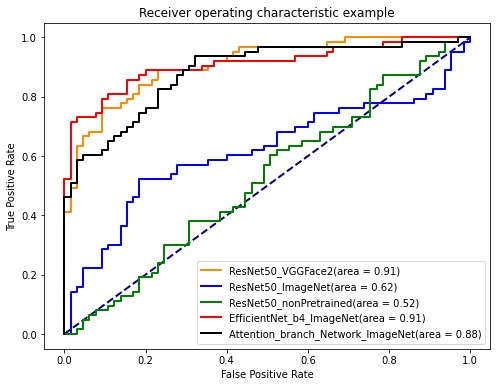

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_score = []
y_true = []

k=0
for i in label_list:
    if label_list[k] == 'cont':
          y_true.append(0)
    elif label_list[k] == 'grav':
          y_true.append(1)
    k+=1


#健康な状態を「0」、病気を「1」としてラベルよりリストを作成
y_true = y_true

#グラフの外形を作成
plt.figure(figsize=(8.0, 6.0))
lw = 2
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')

ycolor = ['darkorange','blue','green','red','black']      # 各プロットの色
ylabel = ModelName_list   # 各ラベル

k=0
for i in ModelName_list:
    y_score = model_pred_prob[k]
    fpr, tpr,thred = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=ycolor[k],lw=lw, label=ylabel[k]+'(area = %0.2f)' % roc_auc)
    k+=1

plt.legend(loc="lower right")
plt.show()

In [ ]:
import pandas as pd
import numpy as np

rowname= ModelName_list
colname= ['Accuracy','Positive predictive value','Sensitivity','Specificity','F_value']

df = pd.DataFrame(data=eval_index, index=rowname, columns=colname)
print(df)

df.to_csv("/content/eval_index.csv")

                                   Accuracy  ...   F_value
ResNet50_VGGFace2                  0.812500  ...  0.806452
ResNet50_ImageNet                  0.648438  ...  0.676259
ResNet50_nonPretrained             0.515625  ...  0.523077
EfficientNet_b4_ImageNet           0.835938  ...  0.839695
Attention_branch_Network_ImageNet  0.789062  ...  0.784000

[5 rows x 5 columns]
